In [37]:
import numpy as np
import matplotlib.pyplot as plt 
import torch

from fase.nn.conv import *
import pickle

In [2]:
kernel = np.array([[1,2,3],
                   [2,3,4],
                   [3,4,5]])

arr = np.zeros((32,32))

In [3]:
arr[::2,::2] = np.arange(256).reshape(16,16)

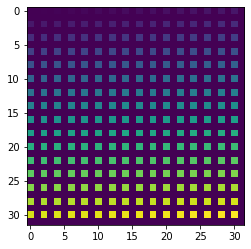

In [4]:
plt.imshow(arr)

In [8]:
rotated = [rotate_input(arr, dilated_kernel.shape)] # channel x (nh * nw)
#rotated = [rotate_input(img2, kernel.shape)] # channel x (nh * nw)

tmp_kernel = kernel[np.newaxis,np.newaxis,::]

conv_out = []
for this_example in rotated:
    result_img = []
    for kk in tmp_kernel:
        result = np.zeros(16*16)
        for this_channel, this_kernel in zip(this_example, kk):
            
            for rr, rk in zip(this_channel, this_kernel.ravel()):
                result += rr * rk
        result_img.append(result.reshape(16,16))
    conv_out.append(np.stack(result_img))
        
#mat_img = np.stack(rotated).T
#out_mat = np.matmul(mat_img, kernel.ravel()) 

In [47]:
def rotate_input_channels(img_tensor_a_batch, f_h, f_w, stride=1):
    # flatten each channel
    imgarrs = [img.ravel() for img in img_tensor_a_batch]
        
    rotated_channels = []
    for imgarr in img_tensor_a_batch:
        rotated_channels.append(rotate_a_channel(imgarr, f_h, f_w, stride=stride))
        
    return rotated_channels

def rotate_a_batch(img_batch, kernel_shape, stride=1):
    """should I handle a batch of images at a time?
    """
    #img_np = img_tensor_a_batch.numpy()
    nb, nc, nh, nw = img_batch.shape
    c_out, c_in, f_h, f_w = kernel_shape
    assert nc == c_in
    
    rotated_batch=[]
    for this_img in img_batch:
        rotated_batch.append(rotate_input_channels(this_img, f_h, f_w, stride=stride))
        
    return rotated_batch

def rotate_a_channel(img, f_h, f_w, stride=1):
    """Make sure order of nh,nw & f_h,f_w match
    """
    nh, nw = img.shape
    imgarr = img.ravel()

    rotated = []
    for i in range(f_h)[::stride]: # 이거를 0,2,4,10,12,14,..가 되도록 
        for j in range(f_w)[::stride]:
            rotated.append(left_rotate(imgarr, (i -1)*nh + (j-1)))

    return rotated

def conv2d(img_tensor, kernel):
    dilated_kernel = np.zeros((5,5))
    dilated_kernel[::2,::2] = kernel

    kernelt = dilated_kernel[np.newaxis, np.newaxis,:,:]

    c_out, c_in, f_h, f_w = kernelt.shape
    n_batch, n_channel, nh, nw = img_tensor.shape

    rotated = rotate_a_batch(img_tensor, kernelt.shape, stride=2)
    out_nh, out_nw = get_out_size((nh, nw), (f_h, f_w), stride=1, padding='same')

    conv_out=[]
    cnt = 0
    for i, this_example in enumerate(rotated[::2]):
        result_each_img =[]
        for j, this_kernel_in_channel in enumerate(kernelt):
            # from 0 - 7
            # multi-channel conv sum

            result_each_out_channel = np.zeros(out_nh * out_nw, dtype=np.float32)
            for k, (this_channel, this_kernel) in enumerate(zip(this_example, this_kernel_in_channel)):
                # from 0 - 2

                ####### single 2D img convolution
                rkernel = this_kernel.ravel() # (f_h * f_w)
                for l, (rr, rk) in enumerate(zip(this_channel, this_kernel[::2,::2].ravel())): 
                #for l in [0,2,4,10,12,14,20,22,24]:
                    # it can simply be done a as vectorized multiplication.
                    # But keeping this form to better relate it with FHE version.
                    #result_each_out_channel += this_channel[l] * rkernel[l]
                    result_each_out_channel += rr * rk
                    if np.sum(rr *rk) ==0:
                        print("dummy")
                    print(i,j,k,l)
                    cnt +=1
                    print("zz", result_each_out_channel)
            result_each_img.append(result_each_out_channel.reshape(out_nh, out_nw))
        conv_out.append(np.stack(result_each_img))
    #return np.stack(conv_out)

    result = np.stack(conv_out)

    return result

0 0 0 0
zz [  0.   0.   0. ... 254.   0. 255.]
0 0 0 1
zz [  0.   0.   0. ... 764.   0. 255.]
0 0 0 2
zz [  0.   0.   0. ... 764.   0. 255.]
0 0 0 3
zz [  0.   0.   0. ... 792.   0. 285.]
0 0 0 4
zz [  0.   0.   0. ... 837.   0. 285.]
0 0 0 5
zz [  0.   0.   0. ... 837.   0. 285.]
0 0 0 6
zz [  0.   0.   0. ... 927.   0. 378.]
0 0 0 7
zz [   0.    0.    0. ... 1051.    0.  378.]
0 0 0 8
zz [   0.    0.    0. ... 1051.    0.  378.]


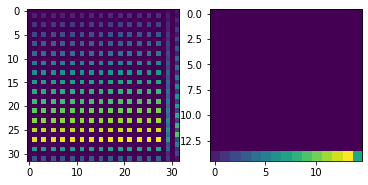

In [32]:
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(result[0,0])
    axs[1].imshow(result[0,0,1:-1:2,1:-1:2] - img_t[1:,1:])
    

In [189]:
rotated = rotate_a_batch(img_tensor, kernelt.shape, stride=2)

In [15]:
print(cnt)

9


### answer

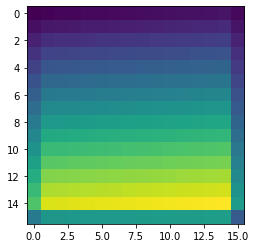

In [12]:
img2 = np.arange(256).reshape(16,16)

res_t = torch.conv2d(torch.tensor(img2[np.newaxis, np.newaxis,:,:]), 
             torch.tensor(kernel[np.newaxis,np.newaxis,:,:]), padding=1)
img_t = res_t.squeeze().numpy()

plt.imshow(img_t)

rotate, dense version

In [28]:
def rotate_input(img, kernel_size, stride=1):
    assert img.ndim == 2
    nx, ny = img.shape
    imgarr = img.ravel()
    f_w, f_h = kernel_size
    
    rotated = []
    for i in range(0, f_w, stride):
        for j in range(0, f_h, stride):
            rotated.append(left_rotate(imgarr, (i -1)*nx + (j-1)))
    return rotated

In [29]:
rotated = rotate_input(img2, (3,3))
mat_img = np.stack(rotated).T

out_mat = np.matmul(mat_img, kernel.ravel()) # 1024 x 9 * 9 x 1 -> 1024 x 1 

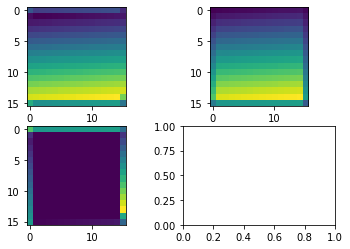

In [24]:
fig, axs = plt.subplots(2,2)

axs[0,0].imshow(out_mat.reshape(16,16))
axs[0,1].imshow(img_t)
axs[1,0].imshow(out_mat.reshape(16,16) - img_t)